# Imports and constants

In [1]:
import os
import time
import random
import collections

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision
from skimage import exposure
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNNHeads
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


# !pip install efficientnet-pytorch
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# !rm -rf EfficientNet EfficientNet-PyTorch
!cp -r ../input/d/kozodoi/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master/efficientnet_pytorch ./efficientnet_pytorch
# from ../input/d/kozodoi/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master import efficientnet_pytorch
# from EfficientNet-PyTorch/EfficientNet-PyTorch-master import efficientnet_pytorch
# import EfficientNet
from efficientnet_pytorch import EfficientNet

def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Fix randomness
fix_all_seeds(42)

In [2]:
!mkdir -p /root/.cache/torch/hub/checkpoints/

# resnet fpn
!cp ../input/maskrcnnresnet50-fpn/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
!cp ../input/resnet101/resnet101-63fe2227.pth /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth

# efficentnet
!cp ../input/efficientnet-pytorch/efficientnet-b3-c8376fa2.pth /root/.cache/torch/hub/checkpoints/efficientnet-b3-c8376fa2.pth

cp: cannot stat '../input/efficientnet-pytorch/efficientnet-b3-c8376fa2.pth': No such file or directory


In [3]:
TRAIN_CSV = "../input/sartorius-cell-instance-segmentation/train.csv"
TEST_PATH = "../input/sartorius-cell-instance-segmentation/test"
TRAIN_PATH = "../input/sartorius-cell-instance-segmentation/train"

cnn_model = "../input/rccn-cell-instance-segmeantation/cell-classification-model.pth"
mask_rcnn_model = "../input/rccn-cell-instance-segmeantation/pytorch_model-e7-loss-1.35550-sgd-5e-05-wd-0.0001.pth"

CELL_TYPES  = {0: 'shsy5y', 1: 'astro', 2: 'cort'}

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)


# The maximum possible amount of predictions
# 539 is the 90% percentile of the cell_type with more instances per image
BOX_DETECTIONS_PER_IMG = 559

# **Dataset Augmentation**

In [4]:
def apply_clahe(img):
    img = img / 255.
    img = exposure.equalize_adapthist(img)

    return img


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target


class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target


class RandomRatation:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, masks):
        if random.random() < self.prob:

            transformT = T.Compose([
                # T.Resize((HEIGHT//2, WIDTH//2)),
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.RandomChoice([
                    T.RandomAffine(degrees=35, scale=(.5, 1.5), translate=(0.1, 0.2), fill=0),
                    T.RandomPerspective(distortion_scale=0.25, fill=0),
                    T.RandomResizedCrop(size = (HEIGHT, WIDTH), scale = (1.5, 2.5))
                ]),
            ])

            transformImg = T.Compose([
                # T.Resize((HEIGHT//2, WIDTH//2)),
                T.RandomAdjustSharpness(sharpness_factor=0.1),
                # T.RandomAutocontrast(),
            ])

            seed = np.random.randint(2147483647)  # make a seed with numpy generator
            random.seed(seed)  # apply this seed to img tranfsorms
            torch.manual_seed(seed)

  
            # print(image.shape)

            image = transformT(image)
            # image = transformImg(image)

            image = apply_clahe(image[0, ...])  
            image = np.stack((image, ) * 3, axis=0)
            image = torch.as_tensor(image, dtype=torch.float32)


            masks = np.array(masks)
            new_masks = np.zeros((masks.shape[0], 
                                  # HEIGHT//2, WIDTH//2
                                  HEIGHT, WIDTH
                                  ), dtype=np.uint8)
            for i, mask in enumerate(masks):
                mask = Image.fromarray((mask).astype(np.uint8))
                random.seed(seed)  # apply this seed to img tranfsorms
                torch.manual_seed(seed)
                mask = transformT(mask)
                new_masks[i, :, :] = mask

            return image, new_masks
        return image, masks


class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target


class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target


def get_transform(train):
    transforms = [ToTensor(), Normalize()]
    if train:
        transforms.append(RandomRatation(1.0))

    return Compose(transforms)


# Load dataframe

In [5]:
df_train = pd.read_csv(TRAIN_CSV)

# Simple statistics: number of instances per image per `cell_type` 

We will use the values from this analysis to decide the number of predicted individuals to generate for each image

In [6]:
df_instances = df_train.groupby(['id']).agg({'annotation': 'count', 'cell_type': 'first'})
df_instances = df_instances.groupby("cell_type")[['annotation']]\
                               .describe(percentiles=[0.1, 0.25, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]).astype(int)\
                               .T.droplevel(level=0).T.drop(['count', '50%', 'std'], axis=1)
df_instances

,mean,min,10%,25%,75%,80%,85%,90%,95%,99%,max
cell_type,,,,,,,,,,,
astro,80,5,28,50,100,105,123,135,150,297,594
cort,33,4,18,23,39,43,46,54,70,93,108
shsy5y,337,49,143,235,429,447,508,539,559,739,790


In [7]:
# Trying with different strategies
df_instances['90%'].to_dict()

{'astro': 135, 'cort': 54, 'shsy5y': 539}

# Simple statistics: Pixels per mask per `cell_type` 

We will use the numbers of this table to refine the masks.

In [8]:
df_train['n_pixels'] = df_train.annotation.apply(lambda x: np.sum([int(e) for e in x.split()[1:][::2]]))
df_pixels = df_train.groupby("cell_type")[['n_pixels']].describe(percentiles=[0.02, 0.05, 0.1, 0.9, 0.95, 0.98])\
                    .astype(int).T.droplevel(level=0).T.drop(['count', '50%', 'std'], axis=1)
df_pixels

,mean,min,2%,5%,10%,90%,95%,98%,max
cell_type,,,,,,,,,
astro,905,37,136,185,251,1799,2380,3447,13327
cort,240,33,74,95,114,404,497,624,2054
shsy5y,224,30,59,77,96,393,478,593,2254


# Models

In [9]:
classifier = torch.load(cnn_model, map_location=DEVICE)
classifier.to(DEVICE)
classifier.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [10]:
maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, image_mean=RESNET_MEAN, image_std=RESNET_STD)


############## ADD PREDICTORS ##############

# get the number of input features for the classifier
in_features = maskrcnn.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
maskrcnn.roi_heads.box_predictor = FastRCNNPredictor(
    in_features, 
    2
)

# now get the number of input features for the mask classifier
in_features_mask = 256
hidden_layer = 256

# and replace the mask predictor with a new one
maskrcnn.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask, 
    hidden_layer, 
    2
)

In [11]:
model = maskrcnn

# modelfile = "../input/rccn-cell-instance-segmeantation/pytorch_model-e6-loss-0.28627-adam-3e-05-wd-0.0005.pth"
modelfile = "../input/rccn-cell-instance-segmeantation/pytorch_model-e11-loss-1.29630-sgd-0.0001-wd-0.0005.pth"
if torch.cuda.is_available():
    checkpoint = torch.load(modelfile)
else:
    checkpoint = torch.load(modelfile, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint)

model.to(DEVICE)
model.train()

# TODO: try removing this for
for param in model.parameters():
    param.requires_grad = True

In [12]:
# anchor_generator = AnchorGenerator(sizes=((8, 16, 32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# backbone = resnet_fpn_backbone('resnet101', True)
# # backbone = resnet_fpn_backbone('resnet50', True)
# model_2 = FasterRCNN(
#     backbone,
#     num_classes=2,
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# )


# # model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, image_mean=RESNET_MEAN, image_std=RESNET_STD)


# ############## ADD PREDICTORS ##############
# # model.roi_heads = maskrcnn.roi_heads
        
# model_2.rpn = maskrcnn.rpn 
# # model.backbone.fpn = maskrcnn.backbone.fpn
    
# # get the number of input features for the classifier
# in_features = model_2.roi_heads.box_predictor.cls_score.in_features

# # replace the pre-trained head with a new one
# model_2.roi_heads.box_predictor = FastRCNNPredictor(
#     in_features, 
#     2
# )

# # now get the number of input features for the mask classifier
# in_features_mask = 1024
# hidden_layer = 256

# # add mask pool
# model_2.roi_heads.mask_roi_pool = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=["0", "1", "2", "3"], 
#     output_size=14, 
#     sampling_ratio=2
# )

# # add mask head
# model_2.roi_heads.mask_head = maskrcnn.roi_heads.mask_head

# out_channels = backbone.out_channels
# mask_layers = (256, 256, 256, 256)
# mask_dilation = 1

# model_2.roi_heads.mask_head = MaskRCNNHeads(
#     out_channels,
#     mask_layers,
#     mask_dilation,
# )


# mask_predictor_in_channels = mask_layers[-1]
# mask_dim_reduced = 256
# # and replace the mask predictor with a new one
# model_2.roi_heads.mask_predictor = MaskRCNNPredictor(
#     mask_predictor_in_channels, 
#     mask_dim_reduced, 
#     2
# )

# modelfile = "../input/rccn-cell-instance-segmeantation/pytorch_model-e16-loss-1.45389-sgd-7e-05-wd-0.0001.pth"
# if torch.cuda.is_available():
#     checkpoint = torch.load(modelfile)
# else:
#     checkpoint = torch.load(modelfile, map_location=torch.device('cpu'))    
# model_2.load_state_dict(checkpoint)

# model_2.to(DEVICE)
# model_2.eval()

# # TODO: try removing this for
# for param in model.parameters():
#     param.requires_grad = True

# Classifier utility functions

In [13]:
# Get the input of the classifier
# The process overlaps a bit with the Mask R-CNN preprocessing
# But they are different
def get_image_for_classifier(image_id):
    image_path = os.path.join(TEST_PATH, image_id + '.png')
#     image_path = os.path.join(TRAIN_PATH, image_id + '.png')
    transforms = A.Compose([A.Resize(224, 224), 
                       A.Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
                       ToTensorV2()])
    image = transforms(image=cv2.imread(image_path))['image']
    return image.unsqueeze(0).to(DEVICE)

# Assess the image_id cell_type with the classifier
def get_image_cell_type(classifier, image_id):
    img = get_image_for_classifier(image_id)
    with torch.no_grad():
        logits = classifier(img)[0]
        cell_type_idx = torch.argmax(logits).item()
    return CELL_TYPES[cell_type_idx]

# Test Dataset

In [14]:
# class CellTestDataset(Dataset):
#     def __init__(self, image_dir):
#         self.image_dir = image_dir
#         self.image_ids = [f[:-4]for f in os.listdir(self.image_dir)]
    
#     def __getitem__(self, idx):
#         image_id = self.image_ids[idx]
#         image_path = os.path.join(self.image_dir, image_id + '.png')
#         image = Image.open(image_path).convert("RGB")
#         image = F.to_tensor(image)
#         return {'image': image, 'image_id': image_id}

#     def __len__(self):
#         return len(self.image_ids)
    
# ds_test = CellTestDataset(TEST_PATH)

In [15]:
class CellTestDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_ids = [f[:-4]for f in os.listdir(self.image_dir)]
        
        self.num_samples = len(self.image_ids)
        self.image_info = collections.defaultdict(dict)
            
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        image = Image.open(image_path).convert("RGB")
        

        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)
            
#         image = np.array(image)
#         image = apply_clahe(image[0, ...])  
#         image = np.stack((image, ) * 3, axis=0)
#         image = torch.as_tensor(image, dtype=torch.float32)
        
        return {'image': image, 'image_id': image_id}

    def __len__(self):
        return len(self.image_ids)

ds_test = CellTestDataset(TEST_PATH, transforms=get_transform(train=False))
# ds_test = CellTestDataset(TRAIN_PATH, transforms=get_transform(train=False))

# Utility functions

In [16]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

# Prediction loop

In [17]:
df_instances.loc['cort', '10%']

18

# Mask refinement function

The masks provided by Mask R-CNN have a probability in each of the pixels and we turn that into a mask thresholding it.

A simple method to do this is to use one fixed number. That is `MASK_THRESHOLD`, which was fixed to `0.5` till now.

Here we propose a refined method. 

The method changes the threshold value in border cases, making sure the number of pixels of the mask is not lower than the `5%` percentile and not higher than the `95%` percentile of the train data for the givel `cell_type`.


In [18]:
CELL_TYPES  = {0: 'shsy5y', 1: 'astro', 2: 'cort'}

In [19]:
def refine_mask(mask, df_pixels, cell_type):
    iters = 30
    idx = list(CELL_TYPES.values()).index(cell_type)
    
    # Minimum number of pixels:
    # The percentile 0.02 of the cell_type in the train set
    min_pixels = df_pixels.loc[cell_type, '2%']
    # Max number of pixels
    # The percentile 0.95 of the cell_type in the train set
    max_pixels = df_pixels.loc[cell_type, '98%']
    
    binary_mask = mask > MASK_THRESHOLD
    if binary_mask.sum() < min_pixels:
        for t in range(iters):
            binary_mask = mask > (MASK_THRESHOLD - t * 0.0001)
            if binary_mask.sum() > min_pixels:
                break
    if binary_mask.sum() > max_pixels:
        for t in range(iters):
            binary_mask = mask > (MASK_THRESHOLD + t * 0.0001)
            if binary_mask.sum() < max_pixels:
                break

    return binary_mask

# Prediction

In [20]:
MIN_SCORE = 0.5

MASK_THRESHOLD = 0.5
# MASK_THRESHOLD = [.45, .35, .55]

In [21]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 12))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [22]:
# submission = []
# classifier.eval()
# model.eval()

# for sample in ds_test:
#     img = sample['image']
#     image_id = sample['image_id']
    
#     # Get classifier prediction: cell_type
#     cell_type = get_image_cell_type(classifier, image_id)
    
#     # Given the cell_type, determine the numnber of instances to predict
#     max_preds = df_instances.loc[cell_type, '95%']
#     # min_preds = df_instances.loc[cell_type, '10%']
    
    
#     # Get Mask R-CNN predictions
#     with torch.no_grad():
#         result = model([img.to(DEVICE)])[0]
    
#     previous_masks = []
#     all_preds_masks = np.zeros((520, 704))
#     for i, mask in enumerate(result["masks"]):
        
#         score = result["scores"][i].cpu().item()
        
#         # Predict at most the 90% number of instances per cell type
#         if i >= max_preds:
#             break
        
#         # Minimum score required for instance to be kept
#         if score < MIN_SCORE:
#             break
        
#         mask = mask.cpu().numpy()
        
#         binary_mask = refine_mask(mask, df_pixels, cell_type)
#         binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
#         all_preds_masks = np.logical_or(all_preds_masks, binary_mask[0, ...])
        
#         previous_masks.append(binary_mask)
#         rle = rle_encoding(binary_mask)
#         submission.append((image_id, rle))
        
#     visualize(
#         image=img.cpu().numpy().transpose((1, 2, 0)),
#         all_preds_masks=all_preds_masks,
#     )
#     # Add empty prediction if no RLE was generated for this image
#     all_images_ids = [image_id for image_id, rle in submission]
#     if image_id not in all_images_ids:
#         submission.append((image_id, ""))

# df_sub = pd.DataFrame(submission, columns=['id', 'predicted'])
# df_sub.to_csv("submission.csv", index=False)
# df_sub.head()

# **TESTING**

In [23]:
model_2 = maskrcnn

modelfile = "../input/rccn-cell-instance-segmeantation/pytorch_model-e6-loss-0.28627-adam-3e-05-wd-0.0005.pth"
# modelfile = "../input/rccn-cell-instance-segmeantation/pytorch_model-e11-loss-1.29630-sgd-0.0001-wd-0.0005.pth"
if torch.cuda.is_available():
    checkpoint = torch.load(modelfile)
else:
    checkpoint = torch.load(modelfile, map_location=torch.device('cpu'))    
model_2.load_state_dict(checkpoint)

model_2.to(DEVICE)
model_2.train()

# TODO: try removing this for
for param in model_2.parameters():
    param.requires_grad = True

In [24]:
MIN_SCORE = 0.5

MASK_THRESHOLD = 0.5

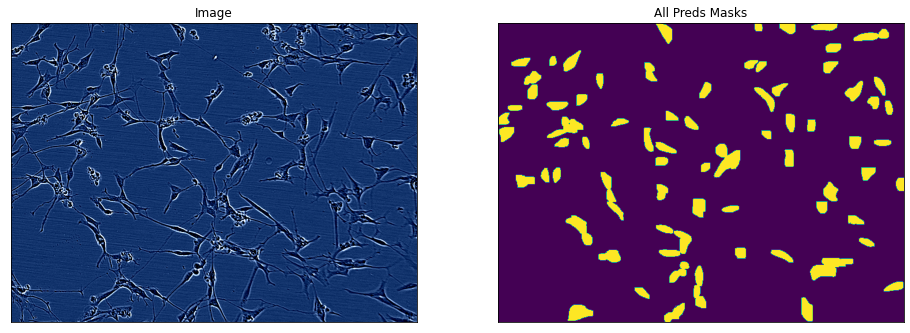

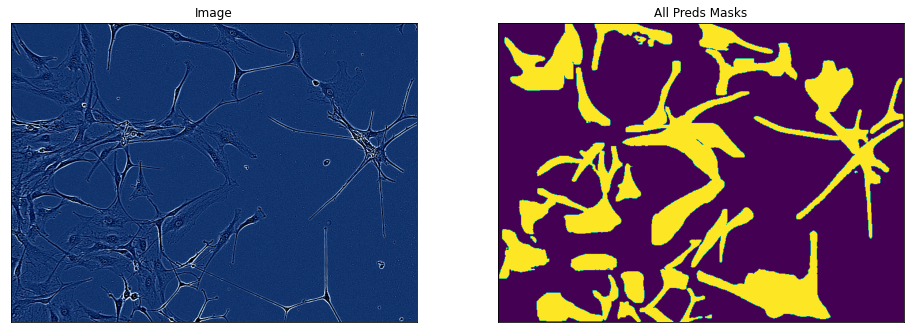

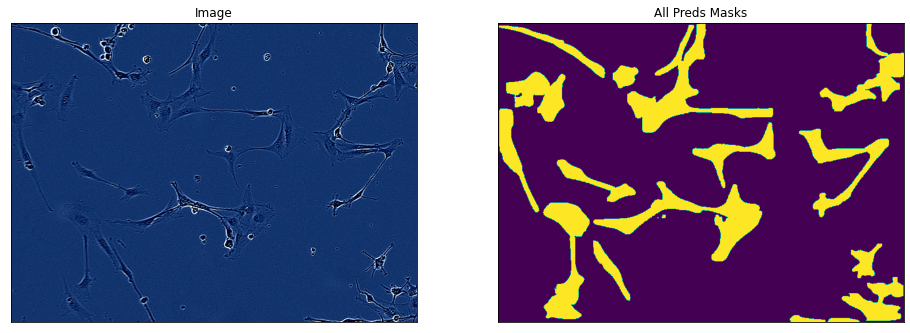

,id,predicted
0,7ae19de7bc2a,140002 18 140706 21 141410 21 142114 21 142818...
1,7ae19de7bc2a,148929 9 149631 12 150334 14 151037 16 151740 ...
2,7ae19de7bc2a,96417 7 97121 8 97824 10 98528 10 99232 11 999...
3,7ae19de7bc2a,207257 7 207958 13 208661 14 209365 15 210069 ...
4,7ae19de7bc2a,178039 25 178743 25 179447 25 180151 25 180855...


In [25]:
submission = []
classifier.eval()
model.eval()
model_2.eval()

for sample in ds_test:
    img = sample['image']
    image_id = sample['image_id']
    
    # Get classifier prediction: cell_type
    cell_type = get_image_cell_type(classifier, image_id)
    
    # Given the cell_type, determine the numnber of instances to predict
    max_preds = df_instances.loc[cell_type, '95%']
    # min_preds = df_instances.loc[cell_type, '10%']
    
    
    # Get Mask R-CNN predictions
    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]
        result_2 = model_2([img.to(DEVICE)])[0]
    
    previous_masks = []
    all_preds_masks = np.zeros((520, 704))
    for i, mask in enumerate(zip(result["masks"], result_2["masks"])):
        mask = mask[0].cpu().numpy() + mask[1].cpu().numpy()
#         plt.imshow(mask[0, ...])
#         plt.show()

#         plt.imshow(mask[1].cpu().numpy()[0, ...])
#         plt.show()
        
        score = (result["scores"][i].cpu().item() + result_2["scores"][i].cpu().item()) / 2.
        
        # Predict at most the 90% number of instances per cell type
        if i >= max_preds:
            break
        
        # Minimum score required for instance to be kept
        if score < MIN_SCORE:
            break
        
#         mask = mask.cpu().numpy()
        
        binary_mask = refine_mask(mask, df_pixels, cell_type)
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        all_preds_masks = np.logical_or(all_preds_masks, binary_mask[0, ...])
        
        previous_masks.append(binary_mask)
        rle = rle_encoding(binary_mask)
        submission.append((image_id, rle))
        
    visualize(
        image=img.cpu().numpy().transpose((1, 2, 0)),
        all_preds_masks=all_preds_masks,
    )
    # Add empty prediction if no RLE was generated for this image
    all_images_ids = [image_id for image_id, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ""))

df_sub = pd.DataFrame(submission, columns=['id', 'predicted'])
df_sub.to_csv("submission.csv", index=False)
df_sub.head()